In [1]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk python-dev python3-dev 
!pip3 install JPype1-py3 
!pip3 install konlpy 
!JAVA_HOME="C:\Program Files\Java\jdk-15.0.1"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:12 http://security.ubuntu.com/ub

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from tqdm import tqdm
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer                                      
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path1 = '/content/drive/My Drive/Colab Notebooks/datasets/nsmc-master/ratings_train.txt'
file_path2 = '/content/drive/My Drive/Colab Notebooks/datasets/nsmc-master/ratings_test.txt'

train_data = pd.read_table(file_path1)
test_data = pd.read_table(file_path2)

In [5]:
print('훈련용 리뷰 개수 :', len(train_data))

print('테스트용 리뷰 개수 :', len(test_data))

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수 : 50000


In [6]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [7]:
# document 열에서 중복인 내용이 있다면 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [8]:
print('총 샘플의 수 :',len(train_data))

print(train_data.groupby('label').size().reset_index(name = 'count'))

총 샘플의 수 : 146183
   label  count
0      0  73342
1      1  72841


In [9]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [10]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [11]:
train_data['document'].replace('', np.nan, inplace=True)

train_data = train_data.dropna(how = 'any')
print(len(train_data))

145791


In [12]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995


In [13]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [14]:
train_data['document'][:5]

0                                    아 더빙 진짜 짜증나네요 목소리
1                           흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                            교도소 이야기구먼 솔직히 재미는 없다평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
Name: document, dtype: object

In [15]:
okt = Okt()

X_train = []
for sentence in tqdm(train_data['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)


100%|██████████| 145791/145791 [09:59<00:00, 243.36it/s]


In [16]:
X_test = []
for sentence in tqdm(test_data['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

100%|██████████| 48995/48995 [03:34<00:00, 228.50it/s]


In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [18]:
type(tokenizer)

keras_preprocessing.text.Tokenizer

In [20]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [21]:
# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value


In [22]:
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [23]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19417


In [24]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [60]:
import pickle

with open('/content/drive/My Drive/Colab Notebooks/project/nlp/tokenizer_data.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
type(X_train)

list

In [26]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [27]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [28]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145380
145380


In [29]:
for i in range(len(X_train)):
    X_train[i] = np.asarray(X_train[i])

In [30]:
X_train[:5]

array([array([ 51, 455,  17, 261, 660]),
       array([ 934,  458,   42,  603,    2,  215, 1450,   25,  962,  676,   20]),
       array([ 387, 2445,    1, 2316, 5672,    3,  223,   10]),
       array([6493,  106, 8119,  219,   57,    5,   27, 3604]),
       array([ 1024,     1,    30,  9146,    25,   834,     2,  2580,    22,
        1109,   241, 14244,     1,  1077,   255,   241])], dtype=object)

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.002187371027652


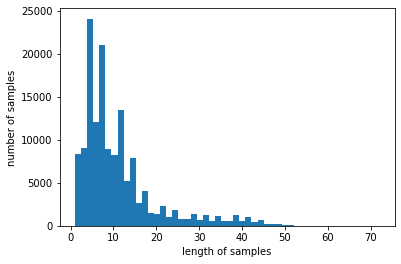

In [31]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [32]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [33]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.0830925849498


In [34]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [35]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [36]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [37]:
vocab_size

19417

In [38]:
total_cnt

43752

In [39]:
rare_cnt

24337

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1941700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,059,077
Trainable params: 2,059,077
Non-trainable params: 0
_________________________________________________________________


In [41]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [42]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'],)
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1935/1939 [============================>.] - ETA: 0s - loss: 0.3888 - acc: 0.8233
Epoch 00001: val_acc improved from -inf to 0.84534, saving model to best_model.h5
1939/1939 [==============================] - 27s 14ms/step - loss: 0.3887 - acc: 0.8234 - val_loss: 0.3490 - val_acc: 0.8453
Epoch 2/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.3253 - acc: 0.8585
Epoch 00002: val_acc improved from 0.84534 to 0.85548, saving model to best_model.h5
1939/1939 [==============================] - 25s 13ms/step - loss: 0.3253 - acc: 0.8585 - val_loss: 0.3317 - val_acc: 0.8555
Epoch 3/15
1937/1939 [============================>.] - ETA: 0s - loss: 0.3002 - acc: 0.8728
Epoch 00003: val_acc improved from 0.85548 to 0.85837, saving model to best_model.h5
1939/1939 [==============================] - 26s 13ms/step - loss: 0.3002 - acc: 0.8728 - val_loss: 0.3283 - val_acc: 0.8584
Epoch 4/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.2822 - acc: 0.8815
E

In [43]:
loaded_model_1 = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model_1.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 5s 3ms/step - loss: 0.3348 - acc: 0.8551

 테스트 정확도: 0.8551


In [61]:
model.save('/content/drive/My Drive/Colab Notebooks/project/nlp/model_1.h5')

In [ ]:
loaded_model_3 = load_model('/content/drive/My Drive/Colab Notebooks/project/nlp/model_1.h5')

In [45]:
loaded_model_2 = load_model('model_1.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model_2.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 5s 3ms/step - loss: 0.3707 - acc: 0.8524

 테스트 정확도: 0.8524


In [54]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model_2.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

sentiment_predict('내용은 평이했으나 신혜선이 예쁘다. 특히 눈매가 참 예쁘다. 사랑스럽다.')

97.82% 확률로 긍정 리뷰입니다.



In [47]:
import os

In [63]:
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/project/nlp/ckpt/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
mc = ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,
                     verbose=1,monitor='val_acc', mode='max',save_best_only=True)

In [64]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1938/1939 [============================>.] - ETA: 0s - loss: 0.1816 - acc: 0.9300
Epoch 00001: val_acc improved from -inf to 0.84823, saving model to /content/drive/My Drive/Colab Notebooks/project/nlp/ckpt/cp.ckpt
1939/1939 [==============================] - 27s 14ms/step - loss: 0.1816 - acc: 0.9300 - val_loss: 0.3983 - val_acc: 0.8482
Epoch 2/15
1939/1939 [==============================] - ETA: 0s - loss: 0.1641 - acc: 0.9371
Epoch 00002: val_acc did not improve from 0.84823
1939/1939 [==============================] - 27s 14ms/step - loss: 0.1641 - acc: 0.9371 - val_loss: 0.4168 - val_acc: 0.8443
Epoch 3/15
1937/1939 [============================>.] - ETA: 0s - loss: 0.1471 - acc: 0.9441
Epoch 00003: val_acc did not improve from 0.84823
1939/1939 [==============================] - 27s 14ms/step - loss: 0.1471 - acc: 0.9441 - val_loss: 0.4571 - val_acc: 0.8390
Epoch 4/15
1935/1939 [============================>.] - ETA: 0s - loss: 0.1304 - acc: 0.9511
Epoch 00004: val_acc

In [50]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


model.load_weights(checkpoint_path)

In [51]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 5s 3ms/step - loss: 0.3764 - acc: 0.8463

 테스트 정확도: 0.8463


In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1941700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,059,077
Trainable params: 2,059,077
Non-trainable params: 0
_________________________________________________________________


In [57]:
import requests
from bs4 import BeautifulSoup

In [58]:
def get_data(url):
    resp = requests.get(url)
    html = BeautifulSoup(resp.content, 'html.parser')
    score_result = html.find('div', {'class': 'score_result'})
    lis = score_result.findAll('li')
    for i, li in enumerate(lis):
        review_text = li.find('p').getText()  # span id = _filtered_ment_0
        review_text = review_text.replace("관람객","")
        review_text = review_text.strip()
        score = li.find('em').getText()

        # 간단하게 리뷰와 점수 프린트만 했습니다.
        print(score.strip(),review_text)
        sentiment_predict(review_text)

In [59]:
test_url = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=193194&type=after' # 테스트 (영화 도굴)
resp = requests.get(test_url)
html = BeautifulSoup(resp.content, 'html.parser')
# result = html.find('div', {'class':'score_total'}).find('strong').findChildren('em')[0].getText()
total_count = 100 #int(result.replace(',', ''))

for i in range(1, int(total_count / 10) + 1):
    url = test_url + '&page=' + str(i)
    print('url: "' + url + '" is parsing....')
    get_data(url)

url: "https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=193194&type=after&page=1" is parsing....
7 킬링타임용 영화 내용은 좀 뻔함 여운 없음
82.82% 확률로 부정 리뷰입니다.

10 이제훈 진짜 멋있당 ㅋㅋㅋ 웃을때마다 심쿵 ㅜㅜ
99.81% 확률로 긍정 리뷰입니다.

10 간만에 진짜 재밌게봄 ㅋㅋㅋㅋ 이제훈 귀ㅇㅕ워 ㅠㅠㅠㅠ
99.92% 확률로 긍정 리뷰입니다.

10 내용은 평이했으나 신혜선이 예쁘다. 특히 눈매가 참 예쁘다. 사랑스럽다.
97.82% 확률로 긍정 리뷰입니다.

10 간만에 진짜 많이 웃었네요 ㅋㅋ 배우들 케미가 끝내줍니다
99.79% 확률로 긍정 리뷰입니다.

10 우울했던 일상에 간만에 통쾌함을 안겨준 영화~
99.37% 확률로 긍정 리뷰입니다.

10 시간가는줄 모르고 봤네요? 진심 개꿀잼
91.86% 확률로 긍정 리뷰입니다.

10 이제훈 이런 캐릭터도 완젼 찰떡이네 ㅋㅋ 요즘시기에 유쾌하게 보기 좋은 영화
99.85% 확률로 긍정 리뷰입니다.

4 뻔한 스토리 박진감없고 그냥 그랬습니다. 리뷰 보면 다 재밌다고 난리던데 알바의심드네요.
99.66% 확률로 부정 리뷰입니다.

10 캐스팅도 좋고, 재미도 좋다
98.63% 확률로 긍정 리뷰입니다.

url: "https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=193194&type=after&page=2" is parsing....
10 이제훈, 조우진, 짠희의 유쾌한 연기, 바로 이거임. 코로나 블루 날려버릴 한국판 오션스일레븐.
99.07% 확률로 긍정 리뷰입니다.

7 주인공 깐죽대다가도 진지할때가 있어야 하는데 끝날때까지 깐죽꺼리기만함
72.39% 확률로 부정 리뷰입니다.

4 보는 내내 영화로는 스토리가 빈약하고 드라마로 나왔음 시청률 잘 나왔겠네 이생각 함. 전개가 너무 뻔해서 좀 지루했음.
98.42% 